In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [2]:
genes = pd.read_csv('gene_positions.txt', sep = '\t', index_col = 1)

In [3]:
amr = pd.read_csv('AMR_genes_MG1655.tsv', 
                  sep = '\t', index_col = 'Gene')
amr.head(1)

,Evidence,Property,Source,PATRIC ID,RefSeq Locus Tag,Alt Locus Tag,Source ID,Source Organism,Product,Function,Classification,Antibiotics Class,Antibiotics,Pubmed,Subject Coverage,Query Coverage,Identity,E-value
Gene,,,,,,,,,,,,,,,,,,
hns,BLAT,Antibiotic Resistance,CARD,fig|511145.12.peg.1285,b1237,VBIEscCol129921_1285,NP_309766.1,Escherichia coli O157:H7 str. Sakai,DNA-binding protein H-NS,NaN,efflux pump conferring antibiotic resistance;g...,NaN,NaN,NaN,100.0,100.0,100.0,1.000000e-70


### strains vs k-12

In [4]:
path = 'DGE/'


Summary for NT12004:
Total genes: 4103
Significantly differentially expressed genes: 63
Upregulated: 27
Downregulated: 36

Summary for NT12173:
Total genes: 4103
Significantly differentially expressed genes: 959
Upregulated: 239
Downregulated: 720

Summary for NT12002:
Total genes: 4103
Significantly differentially expressed genes: 192
Upregulated: 43
Downregulated: 149

Summary for NT12174:
Total genes: 4103
Significantly differentially expressed genes: 316
Upregulated: 93
Downregulated: 223

Summary for NT12175:
Total genes: 4103
Significantly differentially expressed genes: 472
Upregulated: 137
Downregulated: 335


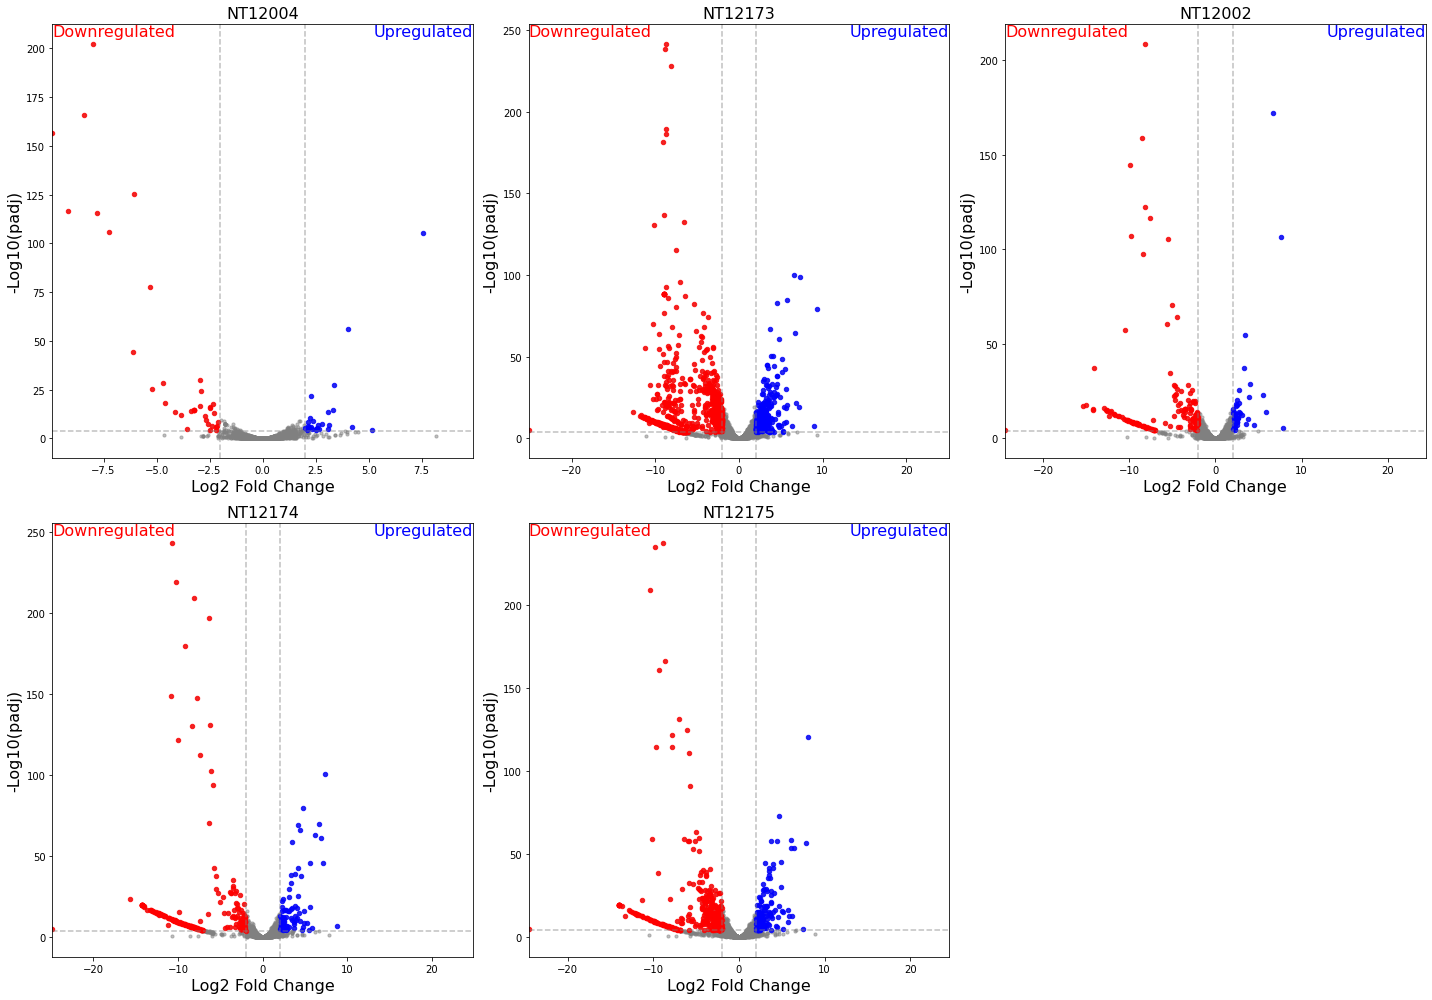

In [24]:
files = [f for f in os.listdir(path) if f.startswith('deseq')]

# Set significance thresholds
padj_threshold = 0.0001
log2fc_threshold = 2  

# List of genes to annotate
genes_to_annotate = ['waaQ', 'waaG','waaP', 'waaS','waaB','waaO','waaJ', 'waaY','waaZ', 'waaU']  

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

for i, file in enumerate(files):
    if i < len(axes):
        
        strain = file.split('_')[-1].split('.')[0]
     
        df = pd.read_csv(os.path.join(path, file), sep='\t', index_col=0)
        df.index = ["_".join(i.split("_cds_")[1].split("_")[:-1]) for i in df.index] 
        df = pd.merge(df, genes[['gene_name']], left_index = True, right_index = True, how ='left').set_index('gene_name')

        
        df['-log10(padj)'] = -np.log10(df['padj'])

        axes[i].scatter(df['log2FoldChange'], df['-log10(padj)'], 
                        alpha=0.5, color='grey', s=10, label='Not significant')

        # Plot significant points
        deg = df[(df['padj'] < padj_threshold) & (abs(df['log2FoldChange']) > log2fc_threshold)]
        upregulated = deg[deg['log2FoldChange'] > log2fc_threshold]
        downregulated = deg[deg['log2FoldChange'] < -log2fc_threshold]

        axes[i].scatter(upregulated['log2FoldChange'], upregulated['-log10(padj)'], 
                        alpha=0.8, color='blue', s=20, label='Upregulated')
        axes[i].scatter(downregulated['log2FoldChange'], downregulated['-log10(padj)'], 
                        alpha=0.8, color='red', s=20, label='Downregulated')

        axes[i].set_xlabel('Log2 Fold Change', fontsize=16)
        axes[i].set_ylabel('-Log10(padj)', fontsize=16)
        axes[i].set_title(f'{strain}', fontsize=16)

        x_lim = max(abs(df['log2FoldChange'].min()), abs(df['log2FoldChange'].max()))
        axes[i].set_xlim(-x_lim, x_lim)

        axes[i].axvline(x=-log2fc_threshold, color='gray', linestyle='--', alpha=0.5)
        axes[i].axvline(x=log2fc_threshold, color='gray', linestyle='--', alpha=0.5)
        axes[i].axhline(y=-np.log10(padj_threshold), color='gray', linestyle='--', alpha=0.5)

        axes[i].text(-x_lim, axes[i].get_ylim()[1], 'Downregulated', color='red', ha='left', va='top', fontsize=16)
        axes[i].text(x_lim, axes[i].get_ylim()[1], 'Upregulated', color='blue', ha='right', va='top', fontsize=16)

    
        # Print summary for each file
        print(f"\nSummary for {strain}:")
        print(f"Total genes: {len(df)}")
        print(f"Significantly differentially expressed genes: {len(deg)}")
        print(f"Upregulated: {len(upregulated)}")
        print(f"Downregulated: {len(downregulated)}")

# Remove extra subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [5]:
test = [472, 316, 959]
control = [63, 192]

# Calculate the mean of test
test_mean = sum(test) / len(test)

# Calculate the mean of control
control_mean = sum(control) / len(control)

print(f"Mean of test: {test_mean}")
print(f"Mean of control: {control_mean}")

Mean of test: 582.3333333333334
Mean of control: 127.5


In [6]:
table = None

for file in os.listdir(path):
    strain = file.split('_')[-1].split('.')[0]
    if file.startswith('deseq'):
        df = pd.read_csv(path + file, sep = '\t', index_col = 0)
        df = df[(df['log2FoldChange'].abs() >= 2) & (df['padj'] < 0.0001)]
        df = df[['log2FoldChange']]
        df = df.rename(columns = {'log2FoldChange' : strain})
        if table is None:
            table = df
        else:
            table = pd.merge(table, df, left_index = True, right_index = True, how = 'outer')
            
deg = table.copy()
deg.index = ["_".join(i.split("_cds_")[1].split("_")[:-1]) for i in deg.index] 
deg = pd.merge(deg, genes[['gene_name']], left_index = True, right_index = True, how ='left')
#deg.to_csv('deg_ecoli_k12.tsv', sep = '\t')
deg.head(2)

,NT12004,NT12173,NT12002,NT12174,NT12175,gene_name
,NaN,-6.552875,NaN,NaN,3.713524,NaN
,NaN,-2.518939,NaN,NaN,NaN,NaN


In [7]:
for col in deg.columns:
    if col.startswith('NT'):
        d = deg[[col, 'gene_name']]
        d = d.dropna()
        d = amr[amr.index.isin(d.gene_name)]
        #d.to_csv(f'amr_{col}.tsv', sep = '\t')

In [8]:
deg_amr = amr[amr.index.isin(deg.gene_name)]
deg_amr.head(2)

,Evidence,Property,Source,PATRIC ID,RefSeq Locus Tag,Alt Locus Tag,Source ID,Source Organism,Product,Function,Classification,Antibiotics Class,Antibiotics,Pubmed,Subject Coverage,Query Coverage,Identity,E-value
Gene,,,,,,,,,,,,,,,,,,
mdtH,BLAT,Antibiotic Resistance,CARD,fig|511145.12.peg.1107,b1065,VBIEscCol129921_1107,AAC74149.2,Escherichia coli str. K-12 substr. MG1655,Multidrug resistance protein MdtH,NaN,efflux pump conferring antibiotic resistance,NaN,NaN,NaN,100.0,100.0,100.0,1.000000e-233
marA,BLAT,Antibiotic Resistance,CARD,fig|511145.12.peg.1600,b1531,VBIEscCol129921_1600,YP_489794.1,Escherichia coli str. K-12 substr. W3110,Multiple antibiotic resistance protein MarA,NaN,efflux pump conferring antibiotic resistance;g...,NaN,NaN,NaN,100.0,100.0,100.0,4.000000e-70


In [9]:
#heatmaps to visualise expression of waa operon genes and amr genes
deg2 = deg.copy().set_index('gene_name')

waa_genes = ['waaQ', 'waaG','waaP', 'waaS','waaB','waaO','waaJ', 'waaY','waaZ', 'waaU']
amr_genes = list(deg_amr.index)

waa_data = deg2.loc[waa_genes]
amr_data = deg2.loc[amr_genes]

/var/folders/ys/t0s5987940jf4x94c3v464w00000gn/T/ipykernel_1132/3597104043.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("PRGn_r").copy()
  cmap.set_bad(color='whitesmoke')


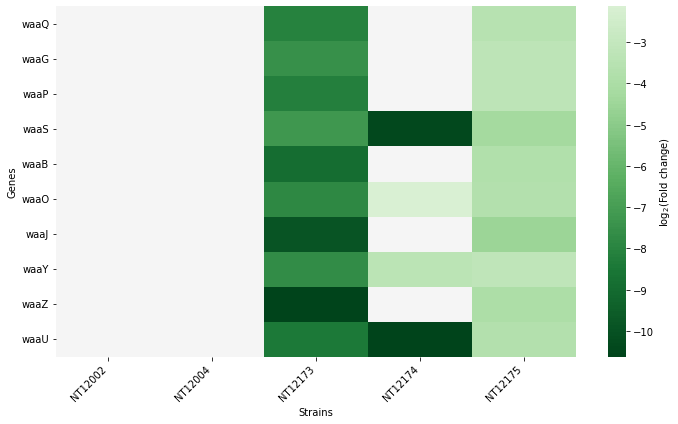

In [13]:
waa_data_sorted = waa_data.sort_index(axis=1)

mask = np.isnan(waa_data_sorted)

# Choose a different color palette
# 'YlOrRd' is a sequential palette that works well for heatmaps
cmap = sns.color_palette("PRGn_r", as_cmap=True)
cmap.set_bad(color='whitesmoke')

plt.figure(figsize=(10, 6))  # Increased figure size for better readability

ax = sns.heatmap(waa_data_sorted, cmap=cmap, center=0, fmt='.2f', 
                 cbar_kws={'label': r'log$_2$(Fold change)'},
                 mask=mask)

plt.xlabel('Strains')
plt.ylabel('Genes')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation = 0, ha = 'right')
# Add a title
#plt.title('Gene Expression Heatmap')

# Adjust layout and display
plt.tight_layout()
plt.savefig('waa_foldchangesr.svg', dpi = 300)
plt.show()

In [ ]:
#heatmaps to visualise expression of waa operon genes and amr genes
deg2 = deg.copy().set_index('gene_name')

amr_genes = ['arnA', 'ompF','hns', 'ugd','basS',]

amr_data = deg2[deg2.index.isin(amr_genes)]

In [19]:
amr_data

,NT12004,NT12173,NT12002,NT12174,NT12175
gene_name,,,,,
ompF,NaN,2.382565,NaN,NaN,NaN
